In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_map(amap: np.array, figsize = (4,4), cmap='Accent'):
    plt.rcParams['figure.figsize'] = figsize
    plt.matshow(amap, cmap=cmap)
    if amap.shape[0] < 50:
        plt.yticks(range(amap.shape[0]))
        plt.xticks(range(amap.shape[1]))
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.5))
        plt.grid(axis="both", which="minor", linewidth=.5)
    else:
        plt.axis('off')

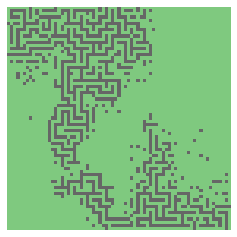

In [46]:
fname = "input18.txt"
n_bytes = 12 
if fname == "input18example.txt":
    n_bytes, grid_size = 12, 7 
else:
    n_bytes, grid_size = 1024, 71

thebytes = set()
with open(fname, "r") as file:
    for _ in range(n_bytes):
        thebytes.add(tuple(int(x) for x in file.readline().split(",")))

grid = np.zeros((grid_size, grid_size))
for pos in thebytes: grid[pos]=1
grid = grid.T
plot_map(grid, figsize=(4,4));

In [47]:
map_graph = {tuple(k): set() for k in np.argwhere(grid==0)}
for pos in map_graph:
    if (pos[0], pos[1]+1) in map_graph:
        map_graph[pos].add((pos[0], pos[1]+1))
        map_graph[(pos[0], pos[1]+1)].add(pos)
    if (pos[0]+1, pos[1]) in map_graph:
        map_graph[pos].add((pos[0]+1, pos[1]))
        map_graph[(pos[0]+1, pos[1])].add(pos)
map_graph = {p:s for p,s in map_graph.items() if s}
start, end = (0,0), max(map_graph.keys())

In [48]:
#simple Dijkstra
def Dijkstra(map_graph:dict, start=(0,0), end=None):
    '''simple Dijkstra, return shortest length to end and distances for every surveyed point till then'''
    if end is None: end=max(map_graph.keys())
    unvisited, distances = set(map_graph.keys()), {point:np.inf for point in map_graph.keys()}
    distances.update({start:0})
    mindist = 0
    next_up = {start} 

    while True: #stopping on break only
        current = {point for point in next_up if distances[point]==mindist}.pop()
        if current == end: break #stop when current point is the endpoint
        next_up.remove(current); unvisited.remove(current)
        for neighbor in map_graph[current].intersection(unvisited):
            distances[neighbor] = min(distances[neighbor], distances[current]+1)
            next_up.add(neighbor)            
        mindist = min(distances[p] for p in next_up) if next_up else np.Inf
        
    return distances[end], distances

#Dijkstra, but recording all shortest paths
def Dijkstra_paths(map_graph:dict, start=(0,0), end=None):
    if end is None: end=max(map_graph.keys())

    unvisited, distances = set(map_graph.keys()), {point: (np.inf, []) for point in map_graph.keys()}
    distances.update({start: (0,[])})
    
    mindist = 0
    next_up = {start} 
    while True: #stopping on break only
        current = {point for point in next_up if distances[point][0]==mindist}.pop()
        if current == end: break #stop when current point is the endpoint
        next_up.remove(current); unvisited.remove(current)
        for neighbor in map_graph[current].intersection(unvisited):
            if distances[current][0]+1 < distances[neighbor][0]:
                distances[neighbor] = (distances[current][0]+1, [current])
            elif distances[current][0]+1 == distances[neighbor][0]:
                distances[neighbor] = (distances[neighbor][0], [current]+distances[neighbor][1])
            next_up.add(neighbor)
        # print(current, distances[current])    
        mindist = min(distances[p][0] for p in next_up) if next_up else np.Inf
        
    return distances[end][0], distances

length:276, one arbitrary path:


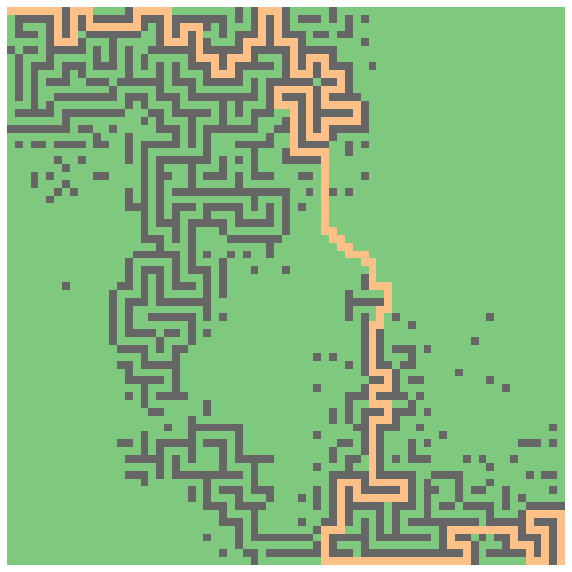

In [49]:
length, distances = Dijkstra_paths(map_graph)
path, current = {end}, end
while current!=start:
    current = distances[current][1][-1]
    path.add(current)
for pos in path: grid[pos]=.25
plot_map(grid, figsize=(10,10))
print(f"length:{length}, one arbitrary path:")

length:276, tiles in optimal paths:432, path multiplicity: 376


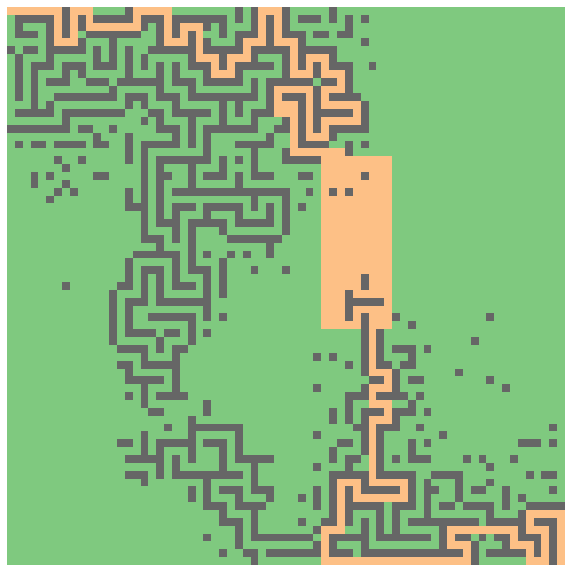

In [41]:
length, distances = Dijkstra_paths(map_graph)
path, next_up, multiplicity = {end}, {end}, 1
while next_up:
    current = next_up.pop()
    path.update(set(distances[current][1]))
    next_up.update(set(distances[current][1]))
    multiplicity += max(0, len(distances[current][1])-1)
for pos in path: grid[pos]=.25
plot_map(grid, figsize=(10,10))
print(f"length:{length}, tiles in optimal paths:{len(path)}, path multiplicity: {(multiplicity)}")

Part II

No need for Dijkstra!

In [50]:
fname = "input18.txt"
grid_size = 7 if fname == "input18example.txt" else 71

thebytes = set()
with open(fname, "r") as file:
    thebytes = file.readlines()
thebytes = [(line.strip("\n").split(",")) for line in thebytes]
thebytes = [tuple(int(x) for x in line) for line in thebytes]
# print(thebytes)

In [51]:
def connected_to(grid :np.array, start :tuple):
    movable_space = set(tuple(p) for p in np.argwhere(grid==0))
    next_up, connected = {start}, {start}
    while next_up:
        current = next_up.pop()
        neighbors = {tuple(np.array(current)+delta) for delta in [(0,1), (1,0), (0,-1), (-1,0)]}
        neighbors = {n for n in neighbors if n in movable_space}.difference(connected)
        next_up.update(neighbors)
        connected.update(neighbors)
    return connected

def slower_connected_to(grid :np.array, start:tuple):
    next_up, connected = {start}, {start}
    while next_up:
        current = next_up.pop()
        neighbors = {tuple(np.array(current)+delta) for delta in [(0,1), (1,0), (0,-1), (-1,0)] \
                 if (0<=np.array(current)+delta).all() and (np.array(current)+delta<grid_size).all()}
        neighbors.difference_update(connected)
        for neighbor in neighbors:
            if grid[neighbor]==0:
                next_up.add(neighbor)
                connected.add(neighbor)
    return connected

Bisection-like search for the cutoff

(60, 37)

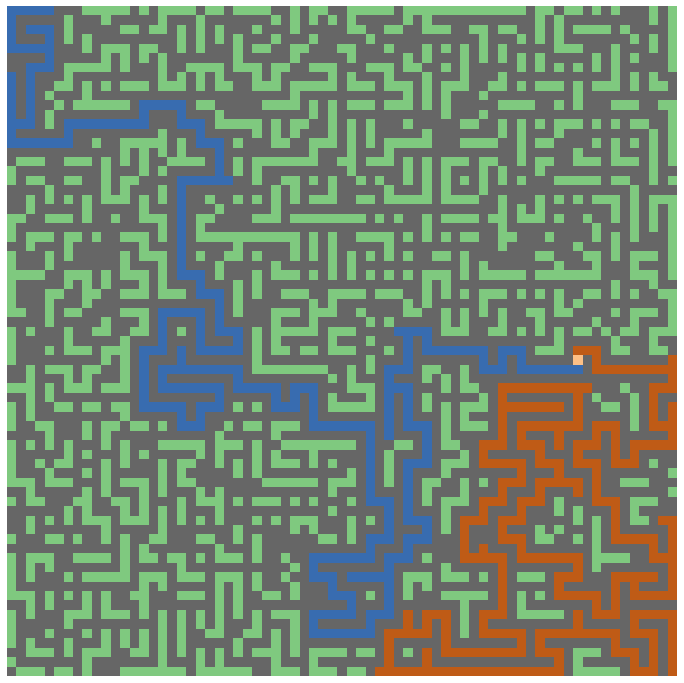

In [54]:
start, end = (0,0), (grid_size-1, grid_size-1)
low_bnd, up_bnd = 1, len(thebytes) #low_bdn always connects, up_bnd never

while up_bnd > low_bnd + 1:
    n = (low_bnd + up_bnd)//2
    grid = np.zeros((grid_size, grid_size))
    for pos in thebytes[:n+1]: grid[pos]=1
    if end in connected_to(grid, start): low_bnd = n
    else: up_bnd = n
    
grid = np.zeros((grid_size, grid_size))
for pos in thebytes[:up_bnd]: grid[pos]=1
conn_before = connected_to(grid, start)
grid[thebytes[up_bnd]]=1
conn_after =  connected_to(grid, start)
for pos in conn_before: grid[pos] = .75
for pos in conn_after : grid[pos] = .5
grid[thebytes[up_bnd]] = .25
plot_map(grid.T, figsize=(12,12), cmap='Accent')
thebytes[up_bnd]